# Embedding Plots

Embedding high-dimensional data into a low-dimensional space (typically 2D or 3D) enables visualization of complex datasets that cannot be understood directly. Many datasets—including images, texts, genomes, simulations, and sensor readings—exist in hundreds or thousands of dimensions, where intuitive notions like distance, similarity, and clustering are difficult to grasp. Dimensionality-reduction methods such as PCA, t-SNE, and UMAP transform this data into lower-dimensional representations that preserve meaningful structure, particularly local neighborhoods or global trends. These methods are generally applicable to any dataset where a meaningful metric exists in the high-dimensional space. In practice, data observations are often represented as high-dimensional embeddings that are then processed into low-dimensional representations.

While it's possible to train an auto-encoder for every data type you encounter, doing so is often both painful and expensive. Furthermore, you may not have enough observations to train a useful encoder of any kind. `dmx-learn` specializes in building generative models for heterogeneous data types of varying lengths. As it turns out, we can leverage built-in tools within `dmx-learn` to obtain low-dimensional embeddings directly.

In this notebook we will: 

1. Show how `dmx-learn` can automatically build a model for a given dataset.
2. Show how posterior embeddings can be used to create low-dimensional embeddings.
3. Outline how `dmx-learn`'s het-SNE extends t-SNE to heterogeneous data types.

This notebook works through an example where simply dropping a feature is not sufficient for obtaining meaningful low-dimensional representations of our data.

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tqdm')
warnings.filterwarnings('ignore', category=UserWarning, module='umap')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from dmx.stats import *
from dmx.utils.estimation import optimize
from dmx.utils.automatic import get_estimator
from dmx.utils.htsne import htsne
from dmx.utils.humap import humap as HUMAP


PATH_TO_DATA = "../data/embedding_data"
TRAIN_DATA = os.path.join(PATH_TO_DATA, "embedding_train_data.csv")


Let's load in the data and see what it looks like.

In [7]:
df = pd.read_csv(TRAIN_DATA)
df["processes"] = df["processes"].apply(lambda x: eval(x))
df.head()

,session_time,key,failed_calls,timer,processes,user
0,1004.361135,UqgH,1,14.049488,[process_9],user1
1,1005.475016,wu,2,1.714437,"[process_28, process_40, process_9]",user1
2,1005.631261,xWBLtYBQG,2,15.655671,"[process_28, process_30, process_49]",user1
3,1006.089735,vXVZfoK,2,11.043926,"[process_47, process_36, process_23, process_3...",user1
4,1005.968783,kgXdjwQ,1,3.273575,"[process_29, process_48, process_50, process_3...",user1


We are going to treat the `user` entry as withheld or unknown information. This will help us determine if the topology of our low-dimensional representations are worthwhile. 

In [8]:
# drop off the true group ids for validation
labels = df["user"].values
df.drop(columns="user", inplace=True)

So we have 5 columns where **key** is categorical (str) and **processes** is a `list[str]`. Let's take a little deeper dig into the data. For starters, let's obtain a list of the unique **key** entries and see how many of them there are.

In [9]:
key_set = df["key"].unique()
num_keys = df["key"].nunique()
print(f"Number of unique key values: {num_keys}")

Number of unique key values: 151


We can also look at the frequency each count occurs in our dataset.

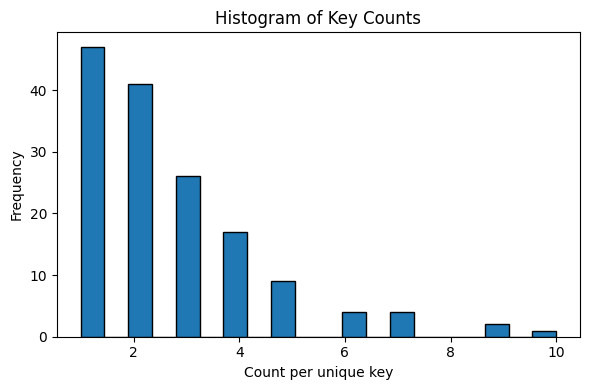

In [11]:
# plot unique key counts
def plot_key_counts(df):
    counts = df['key'].value_counts()
    plt.figure(figsize=(6,4))
    plt.hist(counts, bins=20, edgecolor='black')
    plt.xlabel("Count per unique key")
    plt.ylabel("Frequency")
    plt.title("Histogram of Key Counts")
    plt.tight_layout()
    plt.show()

plot_key_counts(df)

Next up a plot of the features that could easily exist in a metric space of some sort (**session_time**, **failed_calls**, and **timer**).

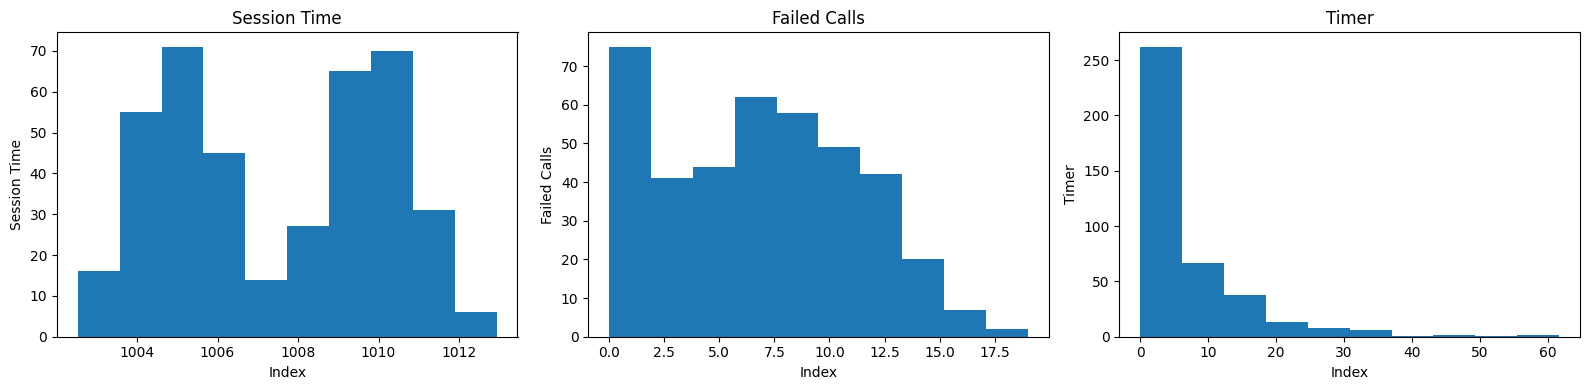

In [12]:
# 3 side by side session_time, failed_calls, timer
def plot_session_metrics(df):
    """
    Create three side-by-side plots from a dataframe with columns:
    'session_time', 'failed_calls', and 'timer'.
    """

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Plot 1: session_time
    axes[0].hist(df['session_time'])
    axes[0].set_title("Session Time")
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel("Session Time")

    # Plot 2: failed_calls
    axes[1].hist(df['failed_calls'])
    axes[1].set_title("Failed Calls")
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("Failed Calls")

    # Plot 3: timer
    axes[2].hist(df['timer'])
    axes[2].set_title("Timer")
    axes[2].set_xlabel("Index")
    axes[2].set_ylabel("Timer")

    plt.tight_layout()
    plt.show()


plot_session_metrics(df)

It looks like **session_time** has some sort of bi-modal shape. This is not particularly interesting but we can take note of it. The values are also sufficiently large enough that we can likely imagine something like a Gaussian distribution representing it.

One other important note: **timer** contains positive values with a heavy mass near 0.0. We will want to keep this in mind when we come back to building `dmx` distributions for this dataset. 

It is not particularly useful, but we can also make a cross-correlation plot.

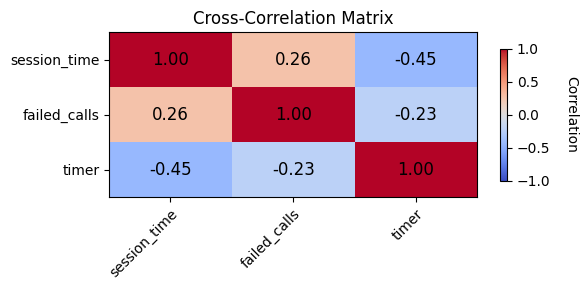

In [16]:
def plot_cross_correlation(df: pd.DataFrame) -> None:
    """
    Create a cross-correlation plot for session_time, failed_calls, and timer.
    """
    # Select only the columns we want to correlate
    cols = ['session_time', 'failed_calls', 'timer']
    corr_df = df[cols]
    
    # Compute correlation matrix
    corr_matrix = corr_df.corr().values
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 3))
    im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(cols)
    
    # Rotate the tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add correlation values as text
    for i in range(len(cols)):
        for j in range(len(cols)):
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Correlation', rotation=270, labelpad=20)
    
    ax.set_title("Cross-Correlation Matrix")
    plt.tight_layout()
    plt.show()

plot_cross_correlation(df)

Alright, now we are going to take a look at **processes**. We should collect all the unique process names and plot the sequence lengths.

In [17]:
process_names = sorted(df["processes"].explode().dropna().unique(), key=lambda x: int(x.split("_")[1]))
print(f"Number of unique process ids: {len(process_names)}")
print(f"Unique IDs: {", ".join(process_names)}")


Number of unique process ids: 56
Unique IDs: process_0, process_1, process_2, process_3, process_4, process_5, process_7, process_8, process_9, process_10, process_11, process_12, process_14, process_15, process_16, process_17, process_19, process_20, process_21, process_22, process_23, process_24, process_25, process_26, process_27, process_28, process_29, process_30, process_31, process_32, process_33, process_34, process_35, process_36, process_37, process_38, process_39, process_40, process_41, process_42, process_43, process_44, process_45, process_46, process_47, process_48, process_49, process_50, process_51, process_52, process_53, process_54, process_55, process_56, process_57, process_58


Number of empty sequences: 8
Max sequence length: 13


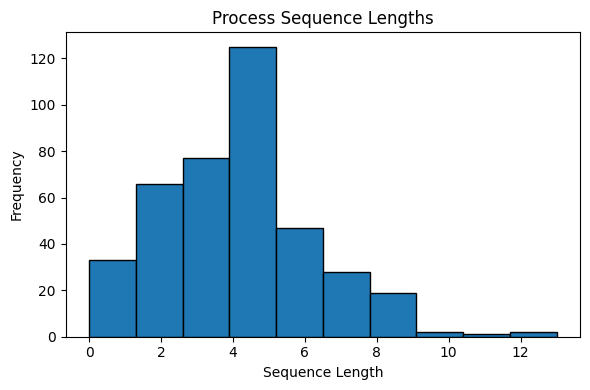

In [20]:
def plot_process_data(df) -> None:
    
    # get list of process length names
    process_lengths = df["processes"].apply(lambda x: len(x))
    print(f"Number of empty sequences: {np.sum(process_lengths==0)}")
    print(f"Max sequence length: {np.max(process_lengths)}")

    plt.figure(figsize=(6,4))
    plt.hist(process_lengths, edgecolor="black")
    plt.title("Process Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_process_data(df)
    

It looks like some sequences are empty and the max size is 13. 

### t-SNE and UMAP with one-hot encodings for low-dimensional representations

Techniques such as **t-SNE** (t-distributed Stochastic Neighbor Embedding) and **UMAP** (Uniform Manifold Approximation and Projection) attempt to construct low-dimensional embeddings that preserve the topology of a high-dimensional space under some given metric. These methods are great for visualizing high-dimensional data. The catch is, you need a metric for the high-dimensional data, and at the least the data must be embedded into a space where a metric is meaningful. 

Next, we are going to compare the embeddings produced by PCA, t-SNE, and UMAP for our dataset. We are going to ignore the process information and one-hot encode the **key** values. We are going to see if we can separate our data into the known user groups in any meaningful way.

In [21]:
train_df = df.copy()
train_df.drop(columns=["processes"], inplace=True)

train_df.head()

,session_time,key,failed_calls,timer
0,1004.361135,UqgH,1,14.049488
1,1005.475016,wu,2,1.714437
2,1005.631261,xWBLtYBQG,2,15.655671
3,1006.089735,vXVZfoK,2,11.043926
4,1005.968783,kgXdjwQ,1,3.273575


Now we are going to one-hot encode **key**. 

In [22]:
one_hot_df = pd.get_dummies(train_df, prefix="key").astype(float)
one_hot_data = one_hot_df.values
one_hot_df.head()

,session_time,failed_calls,timer,key_A,key_AHphaXUx,key_AJVIfWTPU,key_ALoWz,key_AQ,key_Axiuk,key_ByjHxrAgH,...,key_wu,key_xBHPA,key_xWBLtYBQG,key_xWuysL,key_xk,key_y,key_yxikvjG,key_zFWhlS,key_zJWZbWfX,key_zxOSNGCe
0,1004.361135,1.0,14.049488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1005.475016,2.0,1.714437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1005.631261,2.0,15.655671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1006.089735,2.0,11.043926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005.968783,1.0,3.273575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's start off with a simple PCA transformation into 2-dimensions. Note that this is a linear transformation, so we shouldn't really expect great results. 

In [26]:
def get_pca_embeddings(data, seed=42) -> np.ndarray:

    # --- PCA to 2 components ---
    pca = PCA(n_components=2, random_state=seed)
    embedding = pca.fit_transform(data)

    return embedding

def plot_embeddings(embedding: np.ndarray, title: str, method: str) -> None:
    # --- Plot colored by labels ---
    plt.figure(figsize=(7, 5))

    for lbl in np.unique(labels):
        mask = labels == lbl
        plt.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            label=str(lbl),
            s=10
        )

    plt.title(title)
    plt.xlabel(f"{method} 1")
    plt.ylabel(f"{method} 2")
    plt.legend(title="Label", markerscale=2)
    plt.tight_layout()
    plt.show()


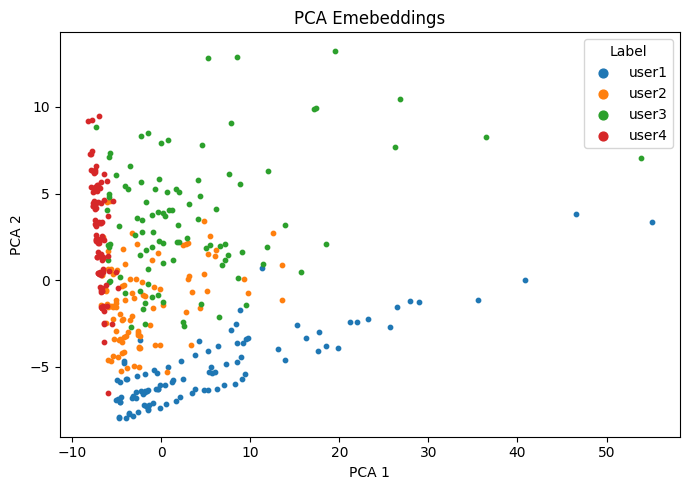

In [27]:
pca_embeddings = get_pca_embeddings(one_hot_data)
plot_embeddings(pca_embeddings, title="PCA Emebeddings", method="PCA")

Well that went as expected. No clustering of any sort. How does t-SNE do?

In [28]:
def get_tsne_embeddings(data, perplexity=30, seed=42) -> np.ndarray:

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate='auto',
        init='pca',
        random_state=seed     # << seed
    )

    embedding = tsne.fit_transform(data)

    return embedding

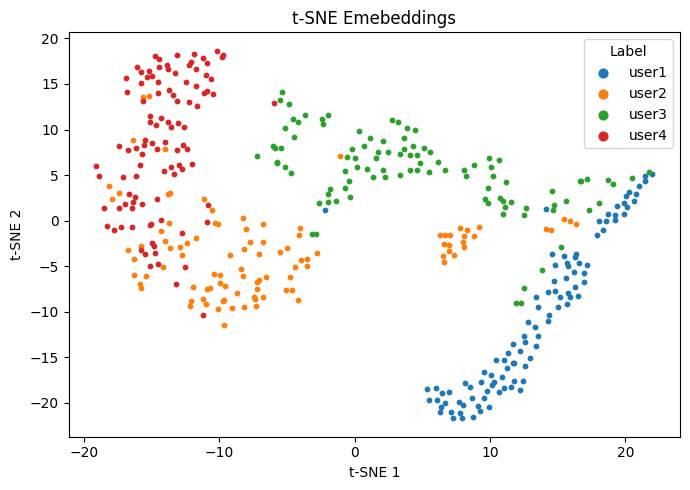

In [32]:
tsne_embeddings = get_tsne_embeddings(one_hot_data)
plot_embeddings(tsne_embeddings, title="t-SNE Emebeddings", method="t-SNE")

This doesn't seem very useful either. There still are not any meaningful groupings. Now let's try UMAP.

In [102]:
def get_umap_embeddings(data, n_neighbors=15, min_dist=0.10, metric="euclidean", seed=42) -> np.ndarray:
    # --- UMAP with fixed seed ---
    umap_model = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=seed      # << seed
    )

    embedding = umap_model.fit_transform(data)

    return embedding 

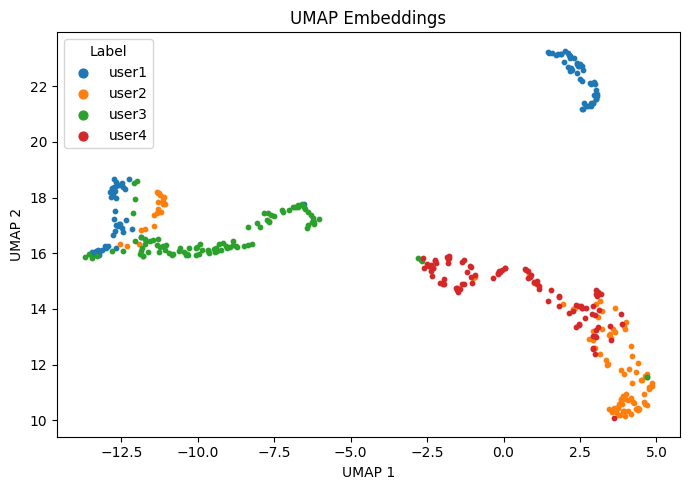

In [71]:
umap_embeddings = get_umap_embeddings(one_hot_data)

plot_embeddings(umap_embeddings, title="UMAP Embeddings", method="UMAP")

It does look like there is some grouping going on. We still don't have very good separation of the known groups (user ids). Let's move on to `dmx` distributions and see if including the process information will help.

### Low-dimensional embedding plots with `dmx` embeddings

`dmx` builds generative probabilistic models that are easy to specify for heterogeneous data types. We are going to formulate `MixtureDistribution`s and use posterior embeddings for each data point to pass to t-SNE and UMAP. There are two approaches we are going to consider:

1. `dmx` automatic estimator selection.
2. Embeddings with self-specified models.
3. het-SNE: A true heterogeneous extension of t-SNE.

Since we are going to use `dmx`, we do not need to bother with the one-hot encoding of the variable `key`. Instead we are simply going to build a `MixtureDistribution` for the data and obtain posterior embeddings. We are going to begin by showing off the `get_estimator` function for automatic estimator selection. 

What does `get_estimator` do? Well, it takes a look at the data and assigns an estimator that is compatible with the data type for a given observation. Let's check it out. We are going to try this out on the data without process information first.

In [72]:
train_data = train_df.values.tolist()
train_df.head()

,session_time,key,failed_calls,timer
0,1004.361135,UqgH,1,14.049488
1,1005.475016,wu,2,1.714437
2,1005.631261,xWBLtYBQG,2,15.655671
3,1006.089735,vXVZfoK,2,11.043926
4,1005.968783,kgXdjwQ,1,3.273575


We need an estimator that supports `tuple[float, str, int, float]`. Now we know that there are some other constraints on the data (i.e. `timer` is positive). We are going to ignore that for now and see how well automatic selection holds up. 

In [73]:
# ignore the flag use_bstats=False for now. This will come up later
auto_est0 = get_estimator(data=train_data, use_bstats=False)

Let's break down what our estimator looks like.

In [74]:
type(auto_est0)

dmx.stats.composite.CompositeEstimator

So `stats_est` is a `CompositeEstimator`, which is what we want since we have a tuple of data. Now let's looks at each components estimator.

In [75]:
for i, comp in enumerate(auto_est0.estimators):
    print(f"Component {i}: {type(comp)}")

Component 0: <class 'dmx.stats.gaussian.GaussianEstimator'>
Component 1: <class 'dmx.stats.categorical.CategoricalEstimator'>
Component 2: <class 'dmx.stats.categorical.CategoricalEstimator'>
Component 3: <class 'dmx.stats.gaussian.GaussianEstimator'>


Alright, so it looks like we have 

- `session_time`: `GaussianEstimator`
- `key`: `CategoricalEstimator`
- `failed_calls`: `CategoricalEstimator`
- `timer`: `GaussianEstimator`

This should work! All that we need to do now is wrap this in a `MixtureEstimator` and fit the model. Later we can consider our own estimator that is a bit more tailored to our EDA.

In [76]:
auto_est = MixtureEstimator([auto_est0]*4)

Make a call to `optimize` to fit the model....

In [77]:
auto_fit = optimize(
    data=train_data,
    estimator=auto_est,
    rng=np.random.RandomState(1),
    max_its=100,
    print_iter=25)

Iteration 25: ln[p_mat(Data|Model)]=-4.847445e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.149598e+00
Iteration 50: ln[p_mat(Data|Model)]=-4.832284e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.117319e-01
Iteration 75: ln[p_mat(Data|Model)]=-4.823720e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=5.062702e-02
Iteration 100: ln[p_mat(Data|Model)]=-4.821630e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=9.858411e-02


We can obtain posterior embeddings from our model fit. We will encode the data so we can make a vectorized call to compute the posteriors in one shot. 

In [78]:
auto_enc_data = seq_encode(data=train_data, model=auto_fit)[0][1]
auto_posteriors = auto_fit.seq_posterior(auto_enc_data)

Let's see how t-SNE handles the posteriors.

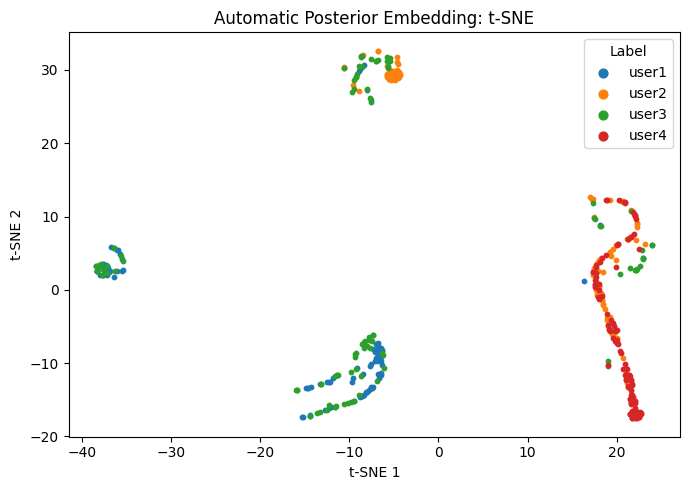

In [79]:
tsne_embeddings = get_tsne_embeddings(auto_posteriors)
plot_embeddings(tsne_embeddings, title="Automatic Posterior Embedding: t-SNE", method="t-SNE")

Now let's try UMAP. Since our posterior embeddings are probability distributions over the mixture components (they live on a simplex), we should use a distance metric appropriate for probability distributions. The **Hellinger distance** is a natural choice for comparing probability distributions on the simplex. 

For two probability distributions $p$ and $q$, the Hellinger distance is defined as:

$$H(p, q) = \frac{1}{\sqrt{2}} \sqrt{\sum_i (\sqrt{p_i} - \sqrt{q_i})^2}$$

The Hellinger distance has several nice properties: it's bounded between 0 and 1, it's symmetric, satisfies the triangle inequality, and is related to the Bhattacharyya coefficient. Unlike KL-divergence, it's a true metric and handles zero probabilities gracefully.

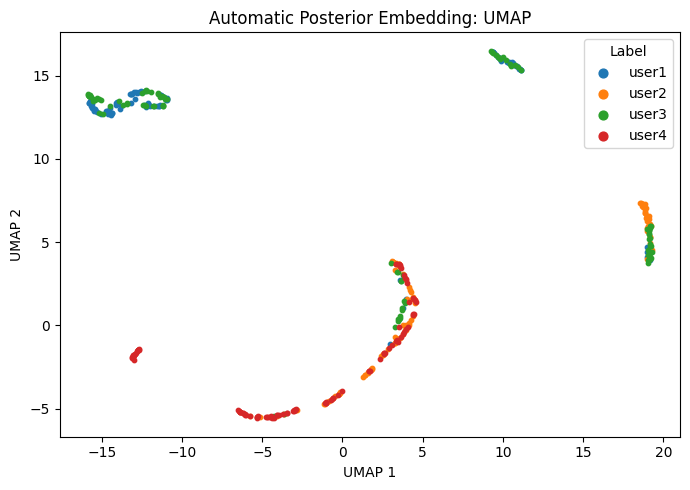

In [81]:
umap_embeddings = get_umap_embeddings(auto_posteriors, metric="hellinger")
plot_embeddings(umap_embeddings, title="Automatic Posterior Embedding: UMAP", method="UMAP")

There still appears to be room for improvement. 

### Now let's try building our own estimator

We know a little bit about the data. For example:

1. `timer` should be positive floats $\rightarrow$ `ExponentialEstimator`
2. `failed_calls` are non-negative integers $\rightarrow$ `PoissonEstimator`

Let's see if this makes much of a difference.

In [ ]:
est0 = GaussianEstimator()
# regularize the keys since we are writing our own estimator
est1 = CategoricalEstimator(suff_stat={k: 1.0 / num_keys for k in key_set}, pseudo_count=1.0)
est2 = PoissonEstimator()
est3 = ExponentialEstimator()

self_est0 = CompositeEstimator([est0, est1, est2, est3])
self_est = MixtureEstimator([self_est0]*4)

Fit the model with `optimize`....

In [96]:
self_fit = optimize(
    data=train_data,
    estimator=self_est,
    rng=np.random.RandomState(16),
    max_its=1000,
    print_iter=25)

Iteration 25: ln[p_mat(Data|Model)]=-4.598521e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=8.055550e+00
Iteration 50: ln[p_mat(Data|Model)]=-4.561959e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=5.799088e-02
Iteration 75: ln[p_mat(Data|Model)]=-4.561623e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.714072e-03
Iteration 100: ln[p_mat(Data|Model)]=-4.561598e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=9.786484e-05
Iteration 125: ln[p_mat(Data|Model)]=-4.561598e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.656172e-06
Iteration 150: ln[p_mat(Data|Model)]=-4.561598e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.868164e-07
Iteration 175: ln[p_mat(Data|Model)]=-4.561598e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.057085e-08
Iteration 200: ln[p_mat(Data|Model)]=-4.561598e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.496098e-09
Iteration 215: ln[p_mat(Data|Model)]=-4.561598e+03, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]

In [97]:
self_enc_data = seq_encode(data=train_data, model=self_fit)[0][1]
self_posteriors = self_fit.seq_posterior(self_enc_data)

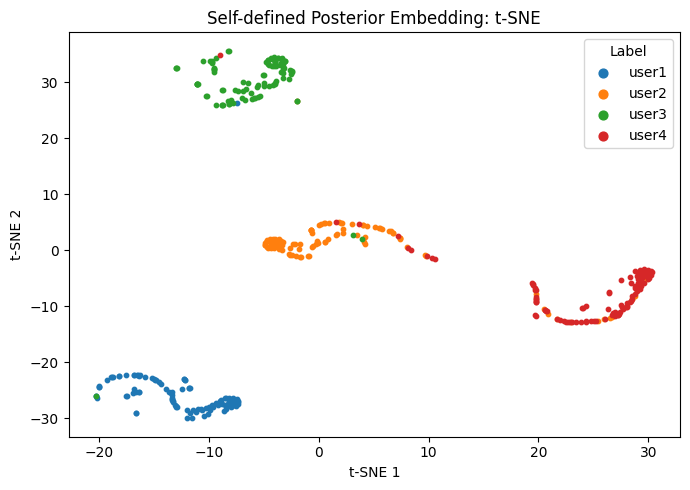

In [98]:
tsne_embeddings = get_tsne_embeddings(self_posteriors)
plot_embeddings(tsne_embeddings, title="Self-defined Posterior Embedding: t-SNE", method="t-SNE")

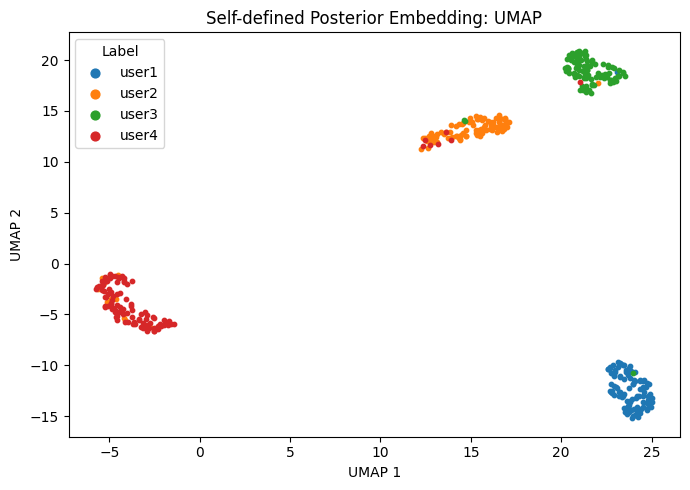

In [108]:
umap_embeddings = get_umap_embeddings(self_posteriors, metric="hellinger", n_neighbors=50, min_dist=0.50, seed=42)
plot_embeddings(umap_embeddings, title="Self-defined Posterior Embedding: UMAP", method="UMAP")

Before we get into modeling the **processes**, let's take a look at some built-in UMAP features in `dmx`. Following the import `from dmx.utils.humap import humap as HUMAP` we can quickly pass a model and key arguments for UMAP to obtain the same plots.

In [100]:
umap_kwargs = {
    "n_components": 2,
    "n_neighbors": 50,
    "min_dist": 0.30,
    "metric": "hellinger",
    "random_state": 42
}

embeddings, _, _, _ = HUMAP(data=train_data, mix_model=self_fit, umap_kwargs=umap_kwargs)

This will return the umap embeddings, the mixture fit, umap fit, and the posteriors. Note that in this case we passed in a pre-fit model. We will look at how this works when we skip that step. 

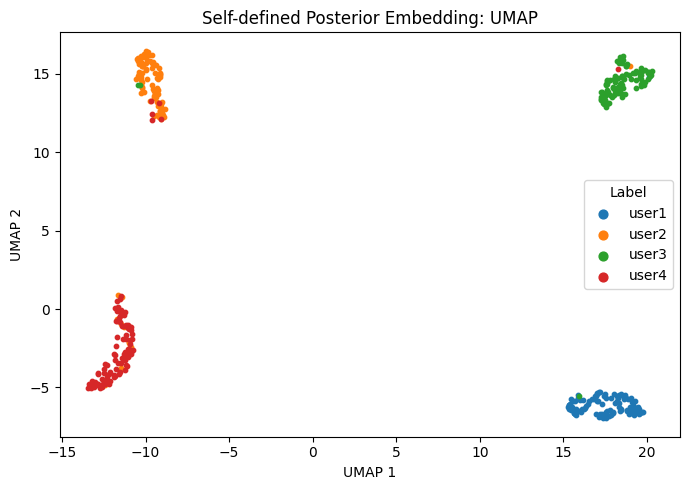

In [109]:
plot_embeddings(embeddings, title="Self-defined Posterior Embedding: UMAP", method="UMAP")

### Extending to the process data

We intentionally excluded the process data when creating these embeddings. Recall that the process sequences were `list[str]` of varying length. Let's repeat our previous work to handle the process sequences.

In [110]:
data = df.values.tolist()
df.head()

,session_time,key,failed_calls,timer,processes
0,1004.361135,UqgH,1,14.049488,[process_9]
1,1005.475016,wu,2,1.714437,"[process_28, process_40, process_9]"
2,1005.631261,xWBLtYBQG,2,15.655671,"[process_28, process_30, process_49]"
3,1006.089735,vXVZfoK,2,11.043926,"[process_47, process_36, process_23, process_3..."
4,1005.968783,kgXdjwQ,1,3.273575,"[process_29, process_48, process_50, process_3..."


Get an automatic estimator.

In [112]:
auto_est0 = get_estimator(data=data, use_bstats=False)

Let's examine the estimator to see what was detected.

In [113]:
for i, comp in enumerate(auto_est0.estimators):
    print(f"Component {i}: {type(comp)}")

Component 0: <class 'dmx.stats.gaussian.GaussianEstimator'>
Component 1: <class 'dmx.stats.categorical.CategoricalEstimator'>
Component 2: <class 'dmx.stats.categorical.CategoricalEstimator'>
Component 3: <class 'dmx.stats.gaussian.GaussianEstimator'>
Component 4: <class 'dmx.stats.sequence.SequenceEstimator'>


Our last component for **processes** is a `SequenceEstimator`. This makes sense since we have sequences of strings. Let's see what the estimator of the `SequenceEstimator` is. 

In [114]:
auto_est0.estimators[-1].estimator

The estimator is a `CategoricalEstimator` which will work since we have strings. Notice that `get_estimator` was able to produce an estimator using a combinator! 

Let's see if a length estimator was specified for the `SequenceEstimator`.

In [115]:
auto_est0.estimators[-1].len_estimator

The length estimator was not included. Also note that no smoothing is performed here, so we may encounter some numeric issues when fitting. We can edit this in-place if we like, but for the sake of example let's just initialize on all the data and move on to fitting the model.

In [117]:
auto_est = MixtureEstimator([auto_est0]*4)

auto_fit = optimize(
    data=data,
    estimator=auto_est,
    rng=np.random.RandomState(22),
    max_its=1000,
    init_p=1.0,
    print_iter=25)

Iteration 25: ln[p_mat(Data|Model)]=-1.086583e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.988302e-01
Iteration 50: ln[p_mat(Data|Model)]=-1.085121e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=5.032946e-01
Iteration 75: ln[p_mat(Data|Model)]=-1.083948e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.531689e-02
Iteration 81: ln[p_mat(Data|Model)]=-1.083725e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=-2.950131e-02


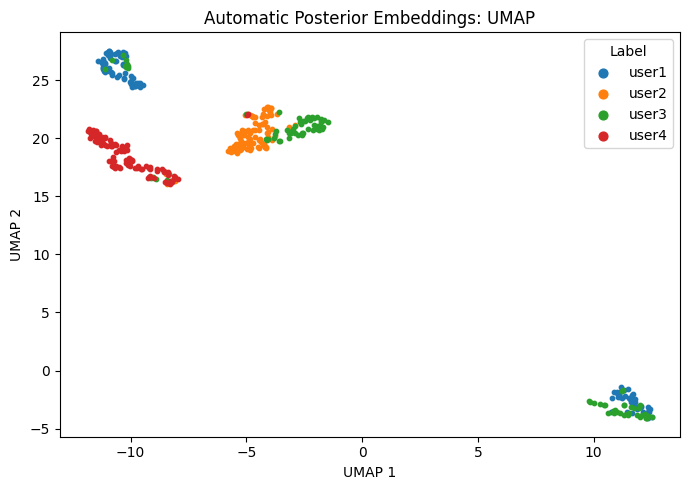

In [118]:
auto_embeddings, _, _, _ = HUMAP(data=data, mix_model=auto_fit, umap_kwargs=umap_kwargs)
plot_embeddings(auto_embeddings, title="Automatic Posterior Embeddings: UMAP", method="UMAP")

That seems worse than excluding the **process** data. Let's try improving the auto-estimator.

In [ ]:
est0 = GaussianEstimator()
# regularize the keys since we are writing our own estimator
est1 = CategoricalEstimator(suff_stat={k: 1.0 / num_keys for k in key_set}, pseudo_count=1.0)
est2 = PoissonEstimator()
est3 = ExponentialEstimator()

# regularize process ids
est40 = CategoricalEstimator(suff_stat={k: 1.0 / len(process_names) for k in process_names}, pseudo_count=1.0)
len_est = PoissonEstimator()
est4 = SequenceEstimator(estimator=est40, len_estimator=len_est)

self_est0 = CompositeEstimator([est0, est1, est2, est3, est4])
self_est = MixtureEstimator([self_est0]*4)

Fitting the model with `optimize`....

In [120]:
self_fit = optimize(
    data=data,
    estimator=self_est,
    rng=np.random.RandomState(72),
    max_its=1000,
    print_iter=25)

Iteration 25: ln[p_mat(Data|Model)]=-1.105880e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.309891e-07
Iteration 31: ln[p_mat(Data|Model)]=-1.105880e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.092726e-10


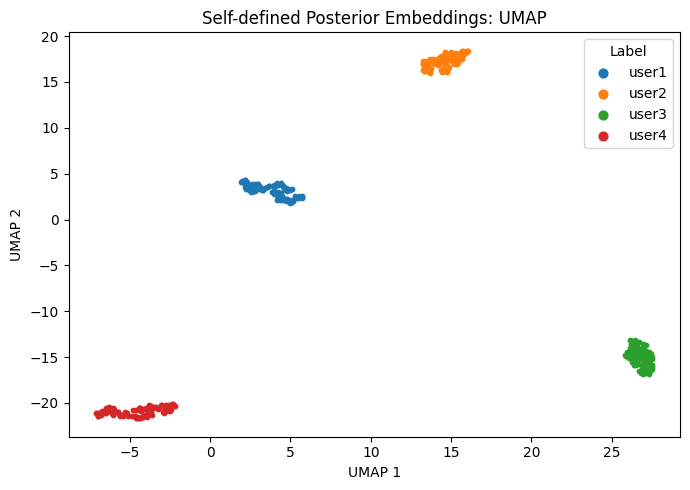

In [121]:
umap_kwargs = {
    "n_components": 2,
    "n_neighbors": 50,
    "min_dist": 0.30,
    "metric": "hellinger",
    "random_state": 42
}

self_embeddings, _, _, _ = HUMAP(data=data, mix_model=self_fit, umap_kwargs=umap_kwargs)
plot_embeddings(self_embeddings, title="Self-defined Posterior Embeddings: UMAP", method="UMAP")

That looks better. It looks like almost all the points are living in 4 clusters. Each point seems to be in the correct group as well (maybe missing a few). So it turns out using all the data was important. `dmx` makes building embeddings for heterogeneous data types easy. 

Instead of concluding here, let's take a look at the real use-case (or at least intended use-case) of automatic estimator detection.

### The intended use-case for automatic detection

`get_estimator` is truly intended to be used to avoid the need of specifying anything from a dataset. Previously we had passed the argument `use_bstats=False` to `get_estimator`. It turns out that this was simply for illustration purposes. 

Under the hood of `HUMAP`, a call to `get_estimator` is made. This call defaults to `use_bstats=True`. Why is this important? Well, it turns out a Dirichlet Process Mixture (DPM) model is fit to the automatically selected estimator under the hood of `HUMAP`. This is nice, as we are also able to avoid directly fixing the number of mixture components (i.e. the DPM places a prior over this). Further, `get_estimator` defaults to selecting priors based on information in the data. This functions as a form of flattening (smoothing) known as empirical Bayes. 

What is the result? We end up with a simple out-of-the-box specification of a model that both selects our number of mixture components for us and smooths our estimators. 

Let's see how this looks.

In [122]:
umap_kwargs = {
    "n_components": 2,
    "n_neighbors": 50,
    "min_dist": 0.30,
    "metric": "hellinger",
    "random_state": 42
}

auto_embeddings, _, _, _ = HUMAP(data=data, seed=51, umap_kwargs=umap_kwargs)

Terminating 40. LL=-11333.151288, dLL=8.544812e-07, MLL=-634.170763, dMLL=-1.471815e-04, VLL=-11333.151288
[0.26816964 0.23554117 0.21968464 0.2088238  0.04229284 0.02477237]
# Components = 6


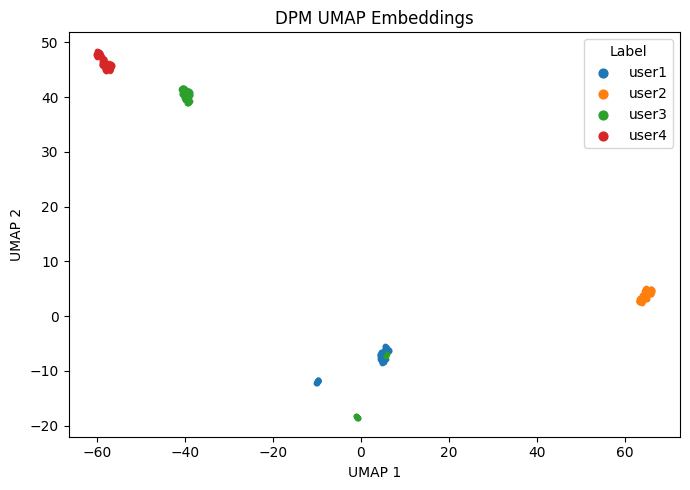

In [123]:
plot_embeddings(auto_embeddings, title="DPM UMAP Embeddings", method="UMAP")

The number of mixture components detected was 6. We see this in the plot above, as there are 6 clusters with almost all the correct ids being assigned to their own group. 

### A true heterogeneous extension of t-SNE

The above is simply a UMAP call to posterior embeddings from a DPM with automatic estimator selection. This was incredibly cheap and easy to fit. It still remains an approximation, as posteriors from mixture models are lossy. 

`dmx` has a built-in extension of t-SNE. Instead of simply obtaining posterior embeddings, het-SNE constructs point clouds based on a distribution over the data. This all happens under the hood, but the result is a more principled approach to obtaining low-dimensional embeddings. Note that this will come at a higher computational cost (much like t-SNE). 

Below we call `htsne` and only pass in the data. A DPM is fit and embeddings are returned.

In [ ]:
from dmx.utils.htsne import htsne

htsne_embeddings = htsne(data=data, seed=51, max_its=1200)

Terminating 40. LL=-11333.151288, dLL=8.544812e-07, MLL=-634.170763, dMLL=-1.471815e-04, VLL=-11333.151288
[0.26816964 0.23554117 0.21968464 0.2088238  0.04229284 0.02477237]
# Components = 6
Iteration 100: alpha = 1.000000, KL(P||Q)=3.152339
Iteration 200: alpha = 1.000000, KL(P||Q)=2.897641
Iteration 100: alpha = 1.000000, KL(P||Q)=3.152339
Iteration 200: alpha = 1.000000, KL(P||Q)=2.897641
Iteration 300: alpha = 1.000000, KL(P||Q)=2.865973
Iteration 400: alpha = 1.000000, KL(P||Q)=2.805964
Iteration 300: alpha = 1.000000, KL(P||Q)=2.865973
Iteration 400: alpha = 1.000000, KL(P||Q)=2.805964
Iteration 500: alpha = 1.000000, KL(P||Q)=2.885458
Iteration 600: alpha = 1.000000, KL(P||Q)=2.813629
Iteration 500: alpha = 1.000000, KL(P||Q)=2.885458
Iteration 600: alpha = 1.000000, KL(P||Q)=2.813629
Iteration 700: alpha = 1.000000, KL(P||Q)=2.800584
Iteration 800: alpha = 1.000000, KL(P||Q)=2.801234
Iteration 700: alpha = 1.000000, KL(P||Q)=2.800584
Iteration 800: alpha = 1.000000, KL(P||Q)=2

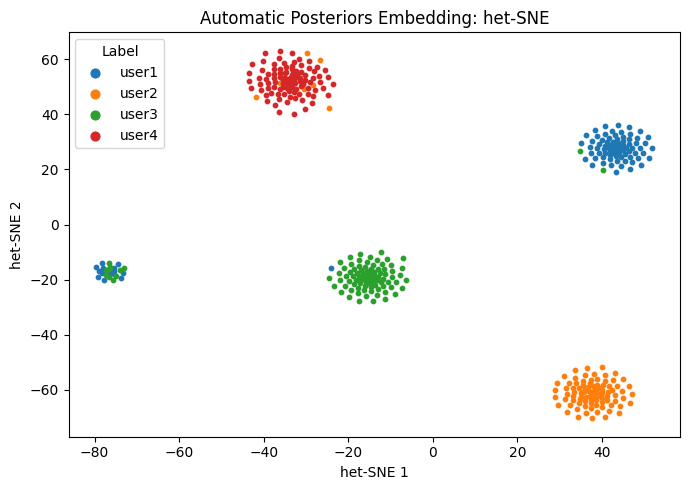

In [128]:
plot_embeddings(htsne_embeddings, title="Automatic Posteriors Embedding: het-SNE", method="het-SNE")